# TLDR
The goals of this notebook:
- validate that our node embedding + clustering approach gives reasonable outcomes for assigning screening groups and assigning community and household-correlated pools

Steps to take:
- construct a graph the same way we did in simulation
- develop a distance metric on the graph, e.g., compute shortest distance using Dijkstra
- compute avg pairwise distance over the graph (can we cache the data?)
- divide into screening groups, compute the avg pairwise distance in each group
- divide nodes in the screening group to community and household correlated pools, compute avg pairwise distance in each pool
- further compute the fraction of households that have all households in the same pool
- report these metrics, validate that HCP is good and creates stronger correlation than CCP

In [1]:
%load_ext autoreload
%autoreload 2

import importlib

import matplotlib.pyplot as plt
import random
import numpy as np
import seirsplus

from seirsplus.viral_model import ViralExtSEIRNetworkModel, VL_PARAMS
from seirsplus.sim_loops_pooled_test import SimulationRunner
from seirsplus.assignment import embed_nodes, get_equal_sized_clusters

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate a social network

In [2]:
import copy

from seirsplus.networks import generate_demographic_contact_network, household_country_data

def generate_population(
    N, country, edge_weight, seed, distancing_scale
):

    random.seed(seed)
    np.random.seed(seed)

    demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                                N=N, demographic_data=household_country_data(country), 
                                                                distancing_scales=[distancing_scale], isolation_groups=[])
    # G = demographic_graphs['baseline']
    G = demographic_graphs[f'distancingScale{distancing_scale}']
    G_weighted = copy.deepcopy(G)
    for e in G.edges():
        if "weight" not in G[e[0]][e[1]]:
            G[e[0]][e[1]]["weight"] = edge_weight
    for e in G_weighted.edges():
        if "weight" not in G_weighted[e[0]][e[1]]:
            G_weighted[e[0]][e[1]]["weight"] = 10**10

    households_dict = {}
    for household in households:
        for node_id in household["indices"]:
            households_dict[node_id] = household["indices"]
    
    return G, G_weighted, households_dict

In [3]:
G, G_weighted, households_dict = generate_population(
    # N=10000, 
    N=10000,
    country='US', edge_weight=10, seed=0, distancing_scale=50)

Generated overall age distribution:
0-9: 0.1179	(-0.0031 from target)
10-19: 0.1252	(-0.0058 from target)
20-29: 0.1423	(0.0053 from target)
30-39: 0.1343	(0.0013 from target)
40-49: 0.1211	(-0.0029 from target)
50-59: 0.1276	(-0.0034 from target)
60-69: 0.1152	(0.0002 from target)
70-79: 0.0743	(0.0043 from target)
80+: 0.0421	(0.0041 from target)

Generated household size distribution:
1: 0.3001	(0.0164 from target)
2: 0.3337	(-0.0114 from target)
3: 0.1442	(-0.0065 from target)
4: 0.1242	(-0.0034 from target)
5: 0.0614	(0.0036 from target)
6: 0.0222	(-0.0005 from target)
7: 0.0141	(0.0017 from target)
Num households: 4105
mean household size: 2.448393594

{'0-9': 1179, '10-19': 1252, '20-29': 1423, '30-39': 1343, '40-49': 1211, '50-59': 1276, '60-69': 1152, '70-79': 743, '80+': 421}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


# Develop a distance metric

Idea: use Floyd-Warshall algorithm to compute all pairwise shortest path. Only need to do this once, just query later for smaller groups.

(think: should we weigh the edges?)

some network-y things for better understanding
- if the adjacency matrix A is binary, unweighted, undirected, taking A to infinite powers characterizes whether two nodes are connected
- how do we "propagate" the information in the adjacency matrix to construct a distance matrix in a dynamic programming fashion? 

In [ ]:
# is this like running Dijkstra for each node?
# how many "passes" do we need to make?

""" 
cost[i.j] at the kth outer iteration: 
the minimum cost from i to j using vertices only from the set {1,2,...,k} as intermediate points

start with cost = adjacency matrix, replace non-edges with infinity

for k in range(n):
   for i in range(n):
      for j in range(n):
         if cost[i,k] + cost[k,j] < cost[i,j]:
            cost[i,j] = cost[i,k] + cost[k,j]

"""




In [4]:
import pickle
sp_dict = dict(nx.all_pairs_shortest_path_length(G))

with open('sp_dict.pkl', 'wb') as f:
    pickle.dump(sp_dict, f)
    

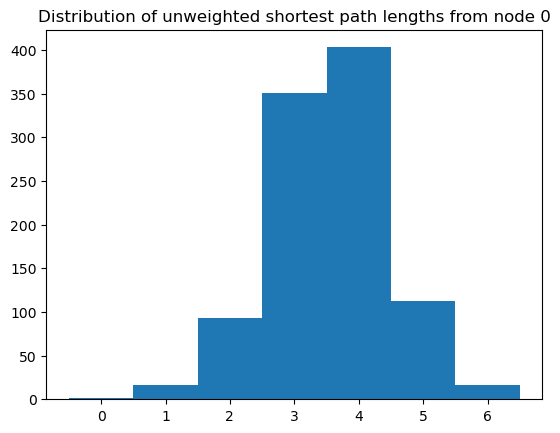

In [6]:
data = list(sp_dict[0].values())

left_of_first_bin = np.min(data) - 1/2
right_of_last_bin = np.max(data) + 1/2

plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + 1, 1))
plt.title("Distribution of unweighted shortest path lengths from node 0")
plt.show()

In [5]:
# compute average pairwise distance

N=10000

current_avg = 0
current_count = 0
avgs = []
population_wide_pairwise_distance = []

# to compute avg pairwise distance on a subgraph, replace range(N) with a list of nodes
for i in range(N):
    for j in range(i+1, N):
        if j in sp_dict[i]:
            avgs.append(current_avg)
            current_count += 1
            current_avg = (current_avg*current_count + sp_dict[i][j])/(current_count+1)
            population_wide_pairwise_distance.append(sp_dict[i][j])



In [6]:
# make a more general function for computing pairwise distance for a list of nodes

def compute_pairwise_distance(G, node_list):
    # take the subgraph of G induced by node_list
    sp_dict = dict(nx.all_pairs_shortest_path_length(G.subgraph(node_list)))
    current_avg = 0
    current_count = 0
    avgs = []
    for i in node_list:
        for j in range(i+1, N):
            if j in sp_dict[i]:
                avgs.append(current_avg)
                current_count += 1
                current_avg = (current_avg*current_count + sp_dict[i][j])/(current_count+1)
    return current_avg

In [7]:
current_avg

4.6659628842472385

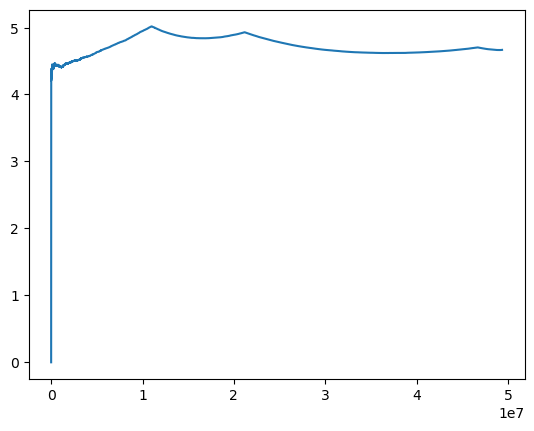

In [8]:
plt.plot(avgs)

In [30]:
households_dict[0]

[0, 246]

In [32]:
# using dijkstra is problematic here because the higher edge weights are interpreted as cost
# so, e.g., you can't tell apart a household edge with weight 10 and a length-10 path with all edges of weight 1

dijkstra_dict = dict(nx.all_pairs_dijkstra_path_length(G))

# Generate screening groups and pools, compute average pairwise distance for each

In [4]:
from seirsplus.assignment import embed_nodes, get_equal_sized_clusters

from seirsplus.viral_model import ViralExtSEIRNetworkModel, VL_PARAMS

VL_params = copy.deepcopy(VL_PARAMS)
for key in ["symptomatic", "asymptomatic"]:
    VL_params[key].update(
        {
            "peak_height": (6,6), 
            "start_peak": (3,5),
            "dt_peak": (1,1)
        }
    )


In [6]:
N=10000

test_model = ViralExtSEIRNetworkModel(
    G = G,
    G_weighted = G_weighted,
    households_dict=households_dict,
    VL_params=VL_params,
    beta = 0.1,
    beta_Q = 0,
    sigma = 0.2,
    lamda = 0.5,
    gamma  = 0.25,
    seed = 0,
    alpha = 2,
    transition_mode="time_in_state",
    initE = N*0.01//2,
    initI_pre = N*0.01//2,
    # initI_pre = N*INIT_PREV,
    verbose=1
)
sim = SimulationRunner(
    model=test_model,
    pooling_strategy="correlated",
    T = 1,
    # num_groups = 10,
    num_groups = 5,
    pool_size = 10, # doesn't matter
    community_size=20,
    LoD=1240,
    seed = 0,
    save_results=False,
    verbose=2,
    max_dt=0.01,
)



Generating walks (CPU: 1): 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


Running simulation with seed 0 for strategy correlated...


In [17]:
# screening groups
for group_id, group_members in sim.screening_groups.items():
    print(compute_pairwise_distance(G, group_members))

3.771683673469386
3.6667572709975547
5.21826280623608
2.479274611398964
4.4405255878285015
2.97940074906367
4.2267284665894005
4.721540178571445
5.010745466756213
4.346348185576491


In [8]:
from collections import defaultdict

within_pool_pairwise_distance = defaultdict(list)
within_pool_num_edges = defaultdict(list)

pool_size = 20

all_household_pools = []

for group_id, group_members in sim.screening_groups.items():

    # community correlated
    community_pools = sim.get_groups(
        G.subgraph(group_members),
        cluster_size = 2*pool_size
    )
    community_pools = [v for _, v in community_pools.items()]
    pools = []
    for community_pool in community_pools:
        random.shuffle(community_pool)
        pools += [
            community_pool[i : i + pool_size]
            for i in range(0, len(community_pool), pool_size)
        ]   
    
    for pool in pools:
        # pool_dist = compute_pairwise_distance(G, pool)
        # within_pool_pairwise_distance["community_correlated"].append(pool_dist)
        within_pool_num_edges["community_correlated"].append(G.subgraph(pool).number_of_edges())

    # naive
    random.shuffle(group_members)
    pools = [
        group_members[i : i + pool_size]
        for i in range(0, len(group_members), pool_size)
    ]
    for pool in pools:
        # pool_dist = compute_pairwise_distance(G, pool)
        # within_pool_pairwise_distance["naive"].append(pool_dist)
        within_pool_num_edges["naive"].append(G.subgraph(pool).number_of_edges())

    # household correlated
    pools = sim.get_groups(
        G.subgraph(group_members),
        cluster_size = pool_size
    )
    pools = [v for _, v in pools.items()]

    all_household_pools += pools

    for pool in pools:
        # pool_dist = compute_pairwise_distance(G, pool)
        # within_pool_pairwise_distance["household_correlated"].append(pool_dist)
        within_pool_num_edges["household_correlated"].append(G.subgraph(pool).number_of_edges())
    


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


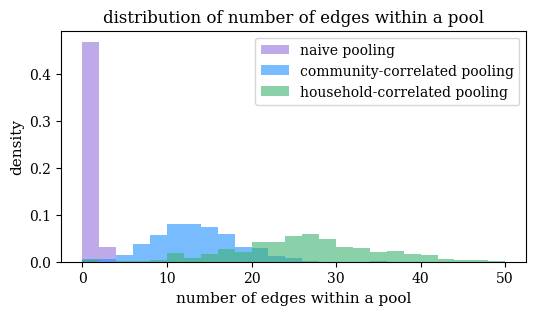

In [37]:
bins = np.linspace(0,50,26)

plt.rcParams["font.family"] = 'serif'
plt.figure(figsize=(6,3))

plt.hist(
    within_pool_num_edges["naive"], alpha=0.6,
    bins=bins, 
    density=True, label = "naive pooling",
    color = "mediumpurple"
)

plt.hist(
    within_pool_num_edges["community_correlated"], alpha=0.6,
    bins=bins, 
    density=True, label = "community-correlated pooling",
    color = "dodgerblue"
)

plt.hist(
    within_pool_num_edges["household_correlated"], alpha=0.6,
    bins=bins, 
    density=True, label = "household-correlated pooling",
    color = "mediumseagreen"
)

plt.title("distribution of number of edges within a pool", fontsize=12)
plt.xlabel("number of edges within a pool", fontsize=11)
plt.ylabel("density", fontsize=11)

plt.legend()
plt.savefig(f'../figures/num_edge_per_pool_distribution.pdf', bbox_inches='tight')

In [10]:
# for each household, compute the number of pools its members belong to


# from households_dict.values(), get the households
# construct a new dict with tuples of household members as keys and the set of pools they belong to as values
# loop over the pools, 
# for each pool, for each member, household_pools[household_dict[node]].add(pool_id)
# finally, count the number of distinct pool ids for each household

from collections import defaultdict

household_pool_tracker = defaultdict(set)
for pool_idx, pool in enumerate(all_household_pools):
    for node in pool:
        household_pool_tracker[tuple(households_dict[node])].add(pool_idx)


In [16]:
num_pools_per_household = [len(v) for v in household_pool_tracker.values()]

In [17]:
max(num_pools_per_household)

5

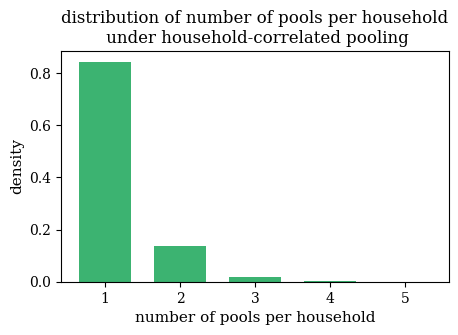

In [36]:

left_of_first_bin = 1/2
right_of_last_bin = 5 + 1/2

plt.rcParams["font.family"] = 'serif'
plt.figure(figsize=(5,3))

plt.hist(
    num_pools_per_household, np.arange(left_of_first_bin, right_of_last_bin + 1, 1), 
    density=True, color = "mediumseagreen",
    rwidth=0.7    
)
plt.title("distribution of number of pools per household\n under household-correlated pooling", fontsize=12)
plt.xlabel("number of pools per household", fontsize=11)
plt.ylabel("density", fontsize=11)
plt.savefig(f'../figures/num_pools_per_household_distribution.pdf', bbox_inches='tight')
plt.show()

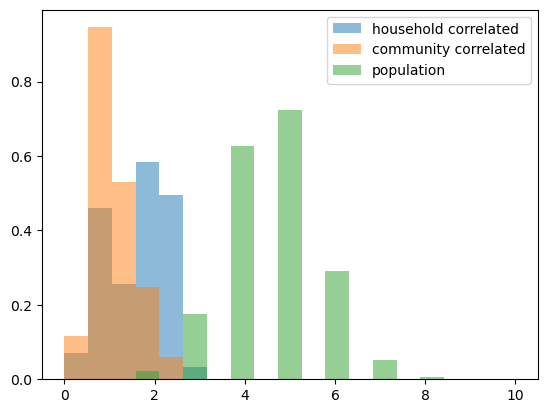

In [12]:
bins = np.linspace(0, 10, 20)
plt.hist(
    within_pool_pairwise_distance["household_correlated"], alpha=0.5,
    bins=bins, density=True, label = "household correlated"
)
plt.hist(
    within_pool_pairwise_distance["community_correlated"], alpha=0.5,
    bins=bins, density=True, label = "community correlated"
)

plt.hist(
    population_wide_pairwise_distance, alpha=0.5,
    bins=bins, density=True, label = "population")

plt.legend()

In [ ]:
# deprecated: Floyd-Warshall algorithm, prohibitively slow

from numpy import inf

def compute_pairwise_distance(G):
    A = adjacency_matrix(G) # check unweighted?
    A[A == 0] = 10**11
    n = A.shape[0]
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if A[i,k] + A[k,j] < A[i,j]:
                    A[i,j] = A[i,k] + A[k,j]
    return A
    
